## Titanic: Machine Learning from Disaster

---
#### References.
https://www.kaggle.com/datasets/shuofxz/titanic-machine-learning-from-disaster?select=train.csv

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

1. ### `train.csv` 데이터 불러오기

In [40]:
df = pd.read_csv('train.csv', encoding='utf-8')

2. ### 상위 5개 데이터 확인

In [41]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


3. ### 결측치 예상 컬럼 확인

In [42]:
df.isna().sum()
# * isnull(), isna() 모두 결측치를 확인하는 함수
#   => 사용자 편의를 위해 2개의 이름으로 제공된다고 함..
#   - isnull : Null 값 여부 확인. 일반적인 프로그래밍에서 사용
#   - isna   : NA 값 여부 확인. 통계학 및 R 언어 등에서 혼합하여 사용

# => Age, Cabin, Embarked 컬럼에 결측치 존재

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

4. ### 다음 Feature 를 기준으로 생존여부를 확인하고자 함. 독립변수와 종속변수 설정.
- 7개 feature 선택 : Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

In [43]:
# 7개의 feature를 독립변수로 설정
# x = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x = df[features]

# 생존여부를 종속변수로 설정
y = df['Survived']

5. ### 결측치 처리
- 나이   (Age) : 중앙값으로 처리
- 탑승지 (Embarked) : 최빈값으로 처리

In [44]:
# x[:,'Age'] = x['Age'].fillna(x['Age'].median())
# x[:,'Embarked'] = x['Embarked'].fillna(x['Embarked'].mode()[0])
# => 경고 메시지 표시되는 코드

x.loc[:,'Age'] = x['Age'].fillna(x['Age'].median())
x.loc[:,'Embarked'] = x['Embarked'].fillna(x['Embarked'].mode()[0])
# loc를 사용하여 명시적으로 열을 지정하여 SettingWithCopyWarning 방지..

---
#### Feature는 크게 범주형(Categorical)과 수치형(Numeric)으로 구분할 수 있음.
#### 범주형 변수(Categorical Feature)
- 값이 ‘종류’를 의미하는 변수
- 수학적 크기 비교가 되지 않고 구분(label)만 되는 데이터.
- ex) 성별: male, female / 탑승 항구: C, Q, S / 색상: red, green, blue / 등급: Gold, Silver, Bronze
- => 모델이 숫자 연산을 못 하기 때문에 인코딩(encoding) 필요

#### 수치형 변수(Numeric Feature)
- 크기, 거리, 평균 등 수학적 연산이 가능한 숫자형 변수
- ex) 나이: 22, 38, 27 / 요금: 7.25, 13.0, 71.28 / 형제 자매 수: 0, 1, 3
- => 스케일(값 범위)이 너무 다르면 학습이 불안정 → 스케일링 필요
---

6. ### 성별(Sex), 탑승지(Embarked) 데이터에 대해 인코딩 처리 (One-Hot Encoding)
  - ##### *인코딩 방법을 찾아본 후, 이해한 내용을 주석으로 정리*

In [45]:
x['Sex'].value_counts() # male, female 문자로 구성된 데이터
x['Embarked'].value_counts() # S, C, Q 문자로 구성된 데이터
# => 값이 연속적인 수치가 아닌 카테고리 형태.

# 인코딩 방법에는 Label Encoding, One-Hot Encoding, Ordinal Encoding 등의 방법이 있음
# - Label Encoding : 각 카테고리를 정수 값으로 매핑하는 방법
# - One-Hot Encoding : 각 카테고리를 0 또는 1 벡터로 변환하는 방법
# - Ordinal Encoding : 순서가 있는 범주형 데이터에 순서대로 숫자를 부여하는 방법

# * One-Hot Encoding
categorical_features = ['Sex', 'Embarked']
x_encoded = pd.get_dummies(x, columns=categorical_features, drop_first=True)
# * get_dummies(data, columns, drop_first)
#   - data : 인코딩 대상 데이터프레임
#   - columns : 인코딩할 범주형 컬럼 목록
#   - drop_first : True 설정 시 첫 번째 카테고리 컬럼 제거하여 다중공선성(Multicollinearity) 방지
#                  => 다중공선성 : 여러 독립 변수(특징, feature)끼리 서로 강하게 연관되어 있는 상태
x_encoded

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True
...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,True,False,True
887,1,19.0,0,0,30.0000,False,False,True
888,3,28.0,1,2,23.4500,False,False,True
889,1,26.0,0,0,30.0000,True,False,False


7. ### 성별(Sex), 탑승지(Embarked)를 제외한 데이터에 대해 스케일링 처리

In [46]:
# 수치형 컬럼 스케일링
scaler = StandardScaler()

num_features = [f for f in features if f not in categorical_features]
print(f' 수치형 컬럼 : {num_features}')

x_encoded[num_features] = scaler.fit_transform(x_encoded[num_features])

 수치형 컬럼 : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


8. ### 전처리가 완료된 데이터를 훈련용, 테스트용으로 분리 (비율 8:2)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)
# * 독립변수는 인코딩, 스케일링 처리된 데이터를 전달!!

9. ### 학습 및 예측한 결과에 대해 오차 행렬(Confusion Matrix)로 결과 확인.

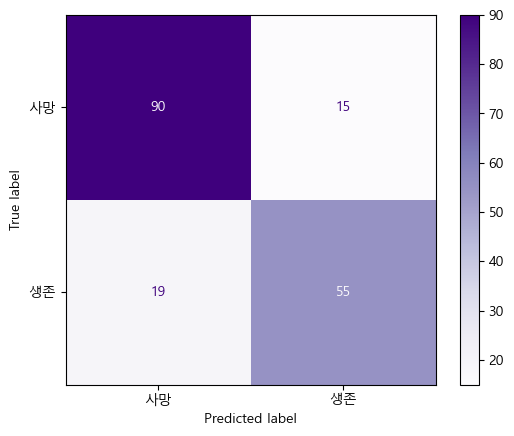

In [51]:
# * 모델 정의
model = LogisticRegression()
# * 학습
model.fit(x_train, y_train)
# * 예측
y_pred = model.predict(x_test)

# * 결과 확인 => 오차 행렬
cm = confusion_matrix(y_test, y_pred)
cm

# * 시각화
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['사망', '생존'])
display.plot(cmap='Purples')

10. ### 분류 보고서 확인

In [53]:
# * 분류 보고서 확인
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

